# Introduction to (Deep) Neural Networks

### Astro Hack Week 2020
### Kyle Boone

***

# Overview

This notebook contains an introduction to artificial neural networks and deep learning. We will first go through the basics of what a neural network is and how it is trained. We will then build a convolutional neural network to classify different galaxy images using the Keras interface to TensorFlow.

***

# Neural networks

### Linear models

A neural network is a function that takes some input $x$, applies a set of transformations to it, and produces one or several outputs. What makes neural networks special is that, if designed properly, they are capable of reproducing any function no matter how complex. To see how a neural network works, let's start with a simple linear model:

$$f(x) = w x + b$$

With the correct choices of the model parameters $w$ and $b$, this model can represent any linear function of the input.

<div>
<img src="images/linear.png" width="500"/>
</div>

Note however that no choice of the parameters $a$ and $b$ will be able to describe a more complex function such as $f(x) = x^2$. We are restricted to modeling linear functions.

### Activation functions

To address this, we can apply an "activation function" $\phi(x)$ to the output of our linear function. There are a range of different activation functions that are suited to different applications, but for simple neural networks they can be used interchangeably. The importance of an activation function is to introduce a nonlinearity into the model.

<div>
<img src="images/multi_activations.png" width="600"/>
</div>

### Neurons

With the activation function $\phi(x)$, our model becomes:

$$f(x) = \phi(w x + b)$$

This new model, that we'll call a "neuron", is only sensitive to a limited region of the inputs: with the sigmoid activation function, for very large values of $x$, $\phi(x)$ outputs a number between 0 and 1 no matter the value of $x$, and there is only a small range of inputs where $\phi(x)$ has a value that isn't close to either 0 or 1. With the appropriate choice of parameters $w$ and $b$, we can tune the range over which this happens. Some examples of different neurons are shown below: 

<div>
<img src="images/neurons.png" width="500"/>
</div>

### Neural networks

Now what happens if we sum the output of all of these different neurons?

<div>
<img src="images/neuron_sum.png" width="500"/>
</div>

We get a function that looks roughly like something quadratic! With our handful of neurons, we can now model nonlinear functions. Each neuron has some range over which it affects the output. You can think of the neural network like a piecewise linear function. If you have enough pieces, and the intervals are small enough, you can model any function!

Note that our neural network outputs something that looks quadratic only for values of $x$ near the origin. For large or small values of $x$, it outputs a constant.

Mathematically, our "neural network" can be written as:

$$f(x) = \sum w_{f,i} \phi(w_{a,i} x + b_{a,i})$$

where $w_{a,i}$ and $b_{a,i}$ are the parameters of each neuron referred to as the weights and biases respectively. We can represent this model with the following graphic:

<div>
<img src="images/simple_nn.png" width="400"/>
</div>

### Complex networks

A neuron can have more than one input. In this case, we simply have a different parameters $a_{ij}$ for each input $x_j$ and our model for a neuron becomes:

$$f(x_i) = \sum_i w_{f,i} \phi\left(\sum_j w_{a,ij} x_j + b_{a,i}\right)$$

Graphically, this can be represented as:

<div>
<img src="images/multi_nn.png" width="400"/>
</div>

We can also build more complex "deep" networks by using the output of a set of neurons as the input to another set of neurons:

$$f(x_i) = \sum_i w_{f,i} \phi\left(\sum_j w_{b,ij} \phi\left(\sum_k w_{a,jk} x_k + b_{a,j}\right) + b_{b,i}\right)$$

<div>
<img src="images/deep_nn.png" width="500"/>
</div>

The layers in between the input and output are called the "hidden layers". Deep neural networks are simply neural networks with many hidden layers (up to ~100 for state-of-the-art models).

A neural network with one hidden layer and an infinite number of neurons can approximate any function with arbitrarily high precision.

***

# Training a neural network

Our neural network is a function with a bunch of parameters. If we want to use our neural network to model some function, we need to set the values of those parameters appropriately. We can "learn" the parameter values by fitting our neural network to some data that we would like to model.

To do this, we need a labeled training set where we know what value we would like the model to output for a given input (e.g. hand-labeled images of galaxies).

## Gradient descent

Given our data and a set of initial randomly-chosen model parameters, we first calculate the output of our neural network. We then define some "loss function" $L$ that captures how bad our predictions are. For example, this could be the mean squared error between the model predictions and the known labels for our training set. We then calculate the derivative of the loss function with respect to each of our model parameters, and take a step $\eta$ in that direction for each of our parameters:

$$w' = w - \eta \frac{\delta L}{\delta w}$$

After doing this many times, we will have a "trained" model that minimizes the loss function.

<div>
<img src="images/gradient_descent_arrow.png" width="400"/>
</div>

For neural networks, we typically used stochastic gradient descent (SGD) where instead of calculating the derivative and performing updates with respect to all of our training set, we only use a small fraction of the dataset (referred to as a "batch") at a time. This significantly decreases the computational load and helps avoid local minima in the loss function.


## Backpropagation

<div>
<img src="images/backprop.png" width="500"/>
</div>

How do we compute the derivative of the loss function with respect to all of our parameters? Well we can just use the chain rule!

$$\frac{\delta L}{\delta w_{a,11}} = \frac{\delta L}{\delta f} \frac{\delta f}{\delta b_1} \frac{\delta b_1}{\delta a_1} \frac{\delta a_1}{\delta w_{a,11}}$$

We can compute these derivatives layer by layer and add them up. This process is referred to as "backpropagation".

## Neural Network Frameworks

It is possible to work out these gradients for small networks, but it gets complicated very quickly when we add more layers. Thankfully, computers are smart and can figure out all of the derivatives for us! There are several packages that have been written to evaluate and train neural networks. In this tutorial, we will use the Keras interface to TensorFlow, a package developed by Google designed to make it easy to build neural networks.

***

# A simple neural network

First, let's build a simple neural network. This has one input, and one output. In the middle, we have two layers of hidden nodes, each of which are fully connected to the input and output. Models like this, where all of the neurons in each layer are connected to all of the nodes in the previous layer, are referred to as "multilayer perceptrons":

<div>
<img src="images/test_nn.png" width="500"/>
</div>

In [1]:
# Setup

# Suppress deprecation warnings. Tensorflow outputs a lot of these.
import warnings
warnings.filterwarnings('ignore')

# Import TensorFlow/keras.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Other imports
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

# Setup matplotlib
%matplotlib inline

## Training the network

Let's train our network to model a sinusoid function. First, let's simulate some noisy measurements.

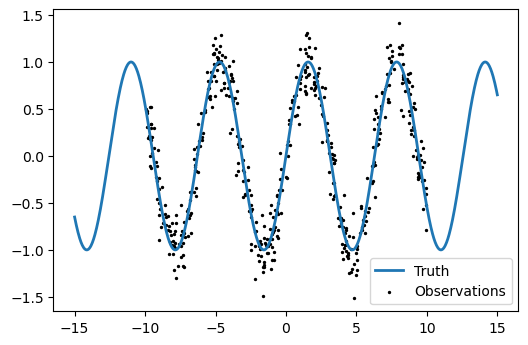

In [2]:
N = 100000
x = np.random.uniform(-10, 10, N)
y = np.sin(x) + np.random.normal(0, 0.2, N)

plt.figure(figsize=(6, 4), dpi=100)
plt.scatter(x[:500], y[:500], s=2, c='k', label='Observations')

plot_x = np.linspace(-15, 15, 1000)
plt.plot(plot_x, np.sin(plot_x), lw=2, label='Truth')
plt.legend()

Now, let's try to have our neural network learn this sinusoid function. Keras will run each of our observations through the neural network, compute the mean-squared error of the neural networks' output compared to the prediction, and backpropagate this error to optimize the parameters of the network.

We will run the optimization for 5 epochs. Each epoch runs the stochastic gradient descent (SGD) algorithm over all of the inputs. This means that the neural network will see each input data point 5 times in total. 

In [3]:
# Build the model
num_neurons = 50
activation = 'tanh'
hidden_layers = 2

# Make a sequential model. This lets us build up the layers one-by-one.
multilayer_perceptron = keras.Sequential(name='multilayer_perceptron')

# Our input has a single element
multilayer_perceptron.add(keras.Input(shape=(1,), name='Input'))

# Add two fully-connected hidden layers
for i in range(hidden_layers):
    multilayer_perceptron.add(layers.Dense(num_neurons, activation=activation, name=f'Hidden_{i}'))

# Add a fully-connected output layer to produce a single value.
multilayer_perceptron.add(layers.Dense(1, name='Output'))

# Show the model details
multilayer_perceptron.summary()

# Compile the model
multilayer_perceptron.compile(loss='mean_squared_error', optimizer='sgd')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "multilayer_perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_0 (Dense)             (None, 50)                100       
_________________________________________________________________
Hidden_1 (Dense)             (None, 50)                2550      
_________________________________________________________________
Output (Dense)               (None, 1)                 51        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Train the model
multilayer_perceptron.fit(x, y, epochs=5)

Epoch 1/5
100000/100000 [==============================] - 3s 32us/sample - loss: 0.3111
Epoch 2/5
100000/100000 [==============================] - 3s 32us/sample - loss: 0.2376
Epoch 3/5
100000/100000 [==============================] - 3s 30us/sample - loss: 0.1309
Epoch 4/5
100000/100000 [==============================] - 3s 32us/sample - loss: 0.0785
Epoch 5/5
100000/100000 [==============================] - 3s 30us/sample - loss: 0.0684


Let's see how we did by evaluating the neural network at a set of points that cover the range that we are interested in.

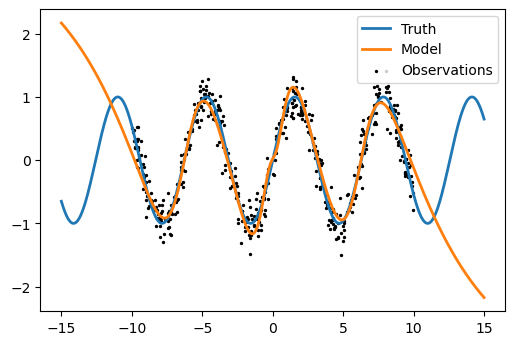

In [5]:
plt.figure(figsize=(6, 4), dpi=100)
plt.scatter(x[:500], y[:500], s=2, c='k', label='Observations')

plot_x = np.linspace(-15, 15, 1000)
plt.plot(plot_x, np.sin(plot_x), lw=2, label='Truth')

plt.plot(plot_x, multilayer_perceptron.predict(plot_x), lw=2, label='Model')

plt.legend()

The neural network "learned" the sinusoid function from the noisy input data. As previously discussed, an infinitely wide neural network can reproduce any function. Note that its predictions outside of the region that we trained it on are not accurate: neural networks are good for interpolating, but typically do not do a good job of extrapolating.

## Exercise:

- What happens when we change the number of neurons?
- Can the neural network learn other functions?
- What happens if we change the number of layers?
- Can we learn from very noisy data?
- How many observations do we need to constrain the model?

***

# Deep learning - galaxy classification

## Convolutional Neural Networks (CNNs)

In astronomy, we often want to use images as inputs to neural networks. In principle, we can treat each pixel as a separate input to the neural network. However, this is inefficient because the CNN is then treating every pixel individually and isn't aware of the spatial structure of the pixels at all.

Convolutional layers are one way of addressing this problem. Instead of having a "fully-connected layer" where each input is connected to each output, we have a kernel with a fixed size, and we only connect the neurons to inputs within this kernel. Additionally, in a convolutional layer, we use the same weights for each of our neurons. This significantly reduces the number of free parameters, and makes it so that the convolutional layer is insensitive to shifts of the input image.

<div>
<img src="images/cnn.png" width="700"/>
</div>

The CNN can have multiple output channels. This is analogous to having R, G and B colors (or different filters in astronomy) for the input image.

## Pooling

For galaxy classification, we would like to take our input image that has some large number of pixels and produce a single output. One way of reducing the size of our images in each layer is to use "max pooling" where we take the maximum value of all of the pixels in a given kernel.

<div>
<img src="images/maxpool.png" width="600"/>
</div>

## Deep convolutional networks

By stacking convolutional layers and pooling layers, we can create a neural network that gradually learns features that cover larger and larger scales of the image. We can then feed this into a fully-connected layer to produce some final output. By stacking convolutional and pooling layers, networks such as AlexNet and VGGNet can classify images with ~90% accuracy.

<div>
<img src="images/vgg16.png" width="700"/>
</div>

# Classifying galaxies

Let's build a CNN to classify images of galaxies. We'll use images of the galaxies from SDSS, with labels from [Nair and Abraham (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJS..186..427N/abstract) for our training set.

This tutorial is inspired by a similar example in [astroML](https://www.astroml.org/book_figures/chapter9/fig_morph_nn.html).

In [6]:
# Load the labels from Nair and Abraham (2010)
metadata = Table.read('/home/kboone/galaxy_data/galaxy_metadata_2000.csv', format='ascii.csv')
metadata[:10]

JID,RA,DEC,z,zconf,g,r,M_g,L_g,Rp_g,Rp50_g,Rp90_g,spID,Mass,Age,g-r,SFRT,SFRM,mu_g,mu_M,M/L,Area,bOverA,seeing_g,NYU-DR4_Object_Tag,n_g,n_r,chi2_g,chi2_r,R50_n,R90_n,V_disp,V_disp_Err,V/Vmax,AGN_Kauffmann,AGN_Kewley,groupid,Ngroup,brightgalflag,massivegalflag,Lum_group,Mass_group,halomass1,halomass2,rho_nyu,rho_Baldry,rhomin_Baldry,rhomax_Baldry,TType,Bar,Ring,Ring_flag,Lens,flag,Pairs,Pair_flag,dist,tails,RC3,Tt
str20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64
J155341.74-003422.84,238.424,-0.573,0.078,1.0,15.82,15.058,-22.089,10.756,18.669,8.807,17.72,343-51692-265,11.083,4.459,0.635,1.014,-9.958,22.631,8.254,0.194,674.81,0.794,1.61,427500.0,2.93,3.56,1452.15,1457.84,5.84,18.65,143.68,7.89,0.805,999999.0,999999.0,148014.0,1.0,1.0,1.0,10.59,10.802,12.949,12.503,6.08,-0.062,-0.075,-0.05,3.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999999,999999.0
J155146.83-000618.62,237.946,-0.105,0.055,1.0,15.512,14.606,-21.566,10.625,12.185,4.578,14.42,343-51692-304,11.245,7.111,0.826,0.896,-10.94,22.439,8.565,0.329,478.974,0.954,1.56,51013.0,3.32,3.45,476.32,280.61,4.24,13.93,204.81,5.36,0.529,3.0,3.0,10223.0,2.0,1.0,1.0,10.559,11.098,12.891,13.015,1.96,-0.241,-0.246,-0.235,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999999,999999.0
J154453.22+002415.48,236.222,0.405,0.034,1.0,15.631,14.838,-20.277,10.072,6.12,2.564,7.452,342-51691-381,10.405,4.287,0.746,-0.012,-10.835,22.47,8.151,0.094,179.239,0.848,1.37,87811.0,2.81,3.05,82.04,116.52,3.61,11.33,129.97,5.46,0.609,0.0,1.0,45472.0,1.0,1.0,1.0,9.999,10.454,11.879,11.981,0.0,-0.616,-0.756,-0.239,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999999,999999.0
J154711.32+002424.81,236.798,0.407,0.033,0.962,15.716,15.158,-20.105,10.467,11.094,6.614,8.955,342-51691-493,10.156,1.901,0.61,1.109,-9.926,22.631,7.848,0.045,203.258,0.854,1.38,51451.0,2.55,3.13,2755.89,3844.55,5.69,17.56,45.25,12.27,0.712,999999.0,999999.0,35234.0,1.0,1.0,1.0,9.943,10.138,11.802,11.695,2.16,-0.136,-0.257,0.259,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999999,999999.0
J154514.39+004619.89,236.31,0.773,0.013,1.0,15.341,14.956,-18.383,9.111,6.917,2.548,4.871,342-51691-430,9.173,1.891,0.566,-1.738,-10.288,22.533,7.333,-0.077,69.221,0.329,1.43,92158.0,2.32,2.27,63.38,21.12,12.79,38.48,89.32,14.59,0.379,999999.0,999999.0,46837.0,1.0,1.0,1.0,-99.0,-99.0,0.0,0.0,0.0,-0.89,-1.832,0.926,5.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,.SAS7?.,999999.0
J155255.43+004304.87,238.231,0.719,0.033,0.999,15.86,15.084,-19.989,9.964,3.46,1.554,4.332,342-51691-637,10.484,6.842,0.735,0.437,-11.138,22.129,8.432,0.265,112.709,0.76,1.58,51997.0,2.63,2.52,17.24,50.02,2.1,6.54,188.82,5.21,0.835,0.0,1.0,35379.0,1.0,1.0,1.0,-99.0,-99.0,0.0,0.0,0.0,-0.262,-0.569,2.426,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999999,999999.0
J155357.40+004117.11,238.49,0.689,0.039,0.998,15.784,15.147,-20.432,10.212,6.882,3.298,7.576,343-51692-377,10.627,2.004,0.583,0.461,-9.978,22.174,8.304,0.273,210.288,0.486,1.51,52004.0,1.22,1.42,72.62,76.61,4.4,10.84,102.61,7.84,0.749,999999.0,999999.0,35380.0,1.0,1.0,1.0,-99.0,-99.0,0.0,0.0,0.0,-0.74,-1.095,1.75,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999999,999999.0
J110122.00-010824.89,165.342,-1.14,0.074,0.999,15.588,14.628,-22.239,10.866,17.776,6.812,21.953,277-51908-126,11.442,7.491,0.8,0.176,-11.327,22.463,8.629,0.28,650.042,0.755,1.95,53000.0,5.11,4.95,181.61,278.13,4.0,13.89,285.78,6.63,0.581,999999.0,999999.0,5436.0,3.0,1.0,1.0,10.901,11.516,13.492,13.637,7.91,999999.0,999999.0,999999.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999999,0.0
J112000.06-010711.96,170.001,-1.119,0.025,0.99,15.97,15.892,-19.164,9.623,3.131,1.546,3.979,

In [7]:
# Load the images
images = np.load('/home/kboone/galaxy_data/galaxy_images_2000.npy')

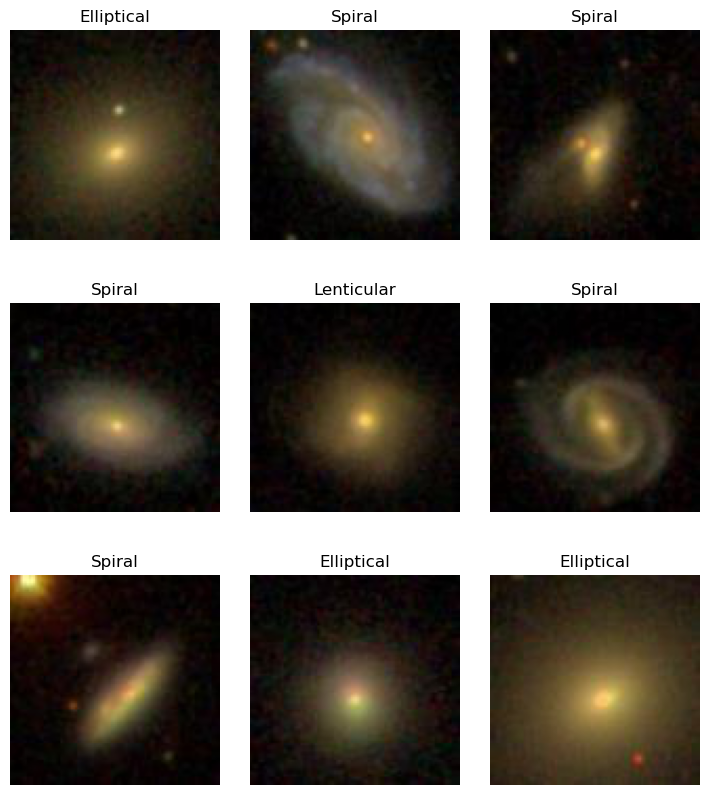

In [8]:
# Plot a few images

def ttype_to_label(ttype):
    if ttype == 99:
        return 'Peculiar'
    elif ttype >= 1:
        return 'Spiral'
    elif ttype >= -3:
        return 'Lenticular'
    else:
        return 'Elliptical'

def plot_images(images, metadata, labels=None):
    fig, axes = plt.subplots(3, 3, figsize=(9, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.1}, dpi=100)

    image_indices = np.random.choice(np.arange(len(images)), 9, False)
    
    for ax, idx in zip(axes.flatten(), image_indices):
        ax.imshow(images[idx])
        ax.axis('off')

        title = ttype_to_label(metadata['TType'][idx])


        if labels is not None:
            title += '\n$p_{spiral}$ = %.2f' % labels[idx, 0]

        ax.set_title(title)

plot_images(images, metadata)

In [9]:
# Let's predict if the image is of a spiral galaxy or of some other kind of galaxy.
# Extract a boolean label for our labeled data representing whether the image is of
# a spiral galaxy.
labels = (metadata['TType'] >= 1) & (metadata['TType'] <= 20)

In [10]:
# Split our sample into training and test subsets
train_images = images[::2]
test_images = images[1::2]
train_metadata = metadata[::2]
test_metadata = metadata[1::2]
train_labels = labels[::2]
test_labels = labels[1::2]

In [11]:
# Build a CNN model for classifying images.

input_size=(100, 100, 3)

model = keras.Sequential()

# Our input images are 100x100 with R, G, and B channels.
model.add(keras.Input(shape=input_size))

model.add(layers.Conv2D(8, 3, padding='same', activation='relu'))

model.add(layers.Conv2D(8, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D(2))

model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D(2))

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D(2))

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D(2))

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D(2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        4640      
____________________________

In [12]:
# Fit the model to our training set
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1000/1000 [==============================] - 11s 11ms/sample - loss: 0.6449 - acc: 0.6310
Epoch 2/5
1000/1000 [==============================] - 11s 11ms/sample - loss: 0.4826 - acc: 0.7790
Epoch 3/5
1000/1000 [==============================] - 11s 11ms/sample - loss: 0.3722 - acc: 0.8460
Epoch 4/5
1000/1000 [==============================] - 11s 11ms/sample - loss: 0.3315 - acc: 0.8640
Epoch 5/5
1000/1000 [==============================] - 11s 11ms/sample - loss: 0.3118 - acc: 0.8810


In [13]:
# Generate predictions for the test set
spiral_probabilities = model.predict(test_images)

Text(0, 0.5, 'Count')

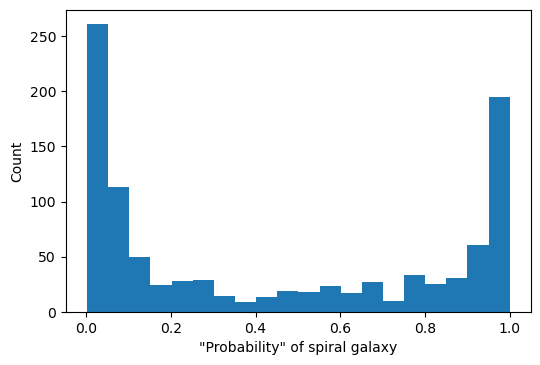

In [14]:
# Make a histogram of the "probabilities" of each image being a spiral galaxy
plt.figure(figsize=(6, 4), dpi=100)
plt.hist(spiral_probabilities, 20);
plt.xlabel('"Probability" of spiral galaxy')
plt.ylabel('Count')

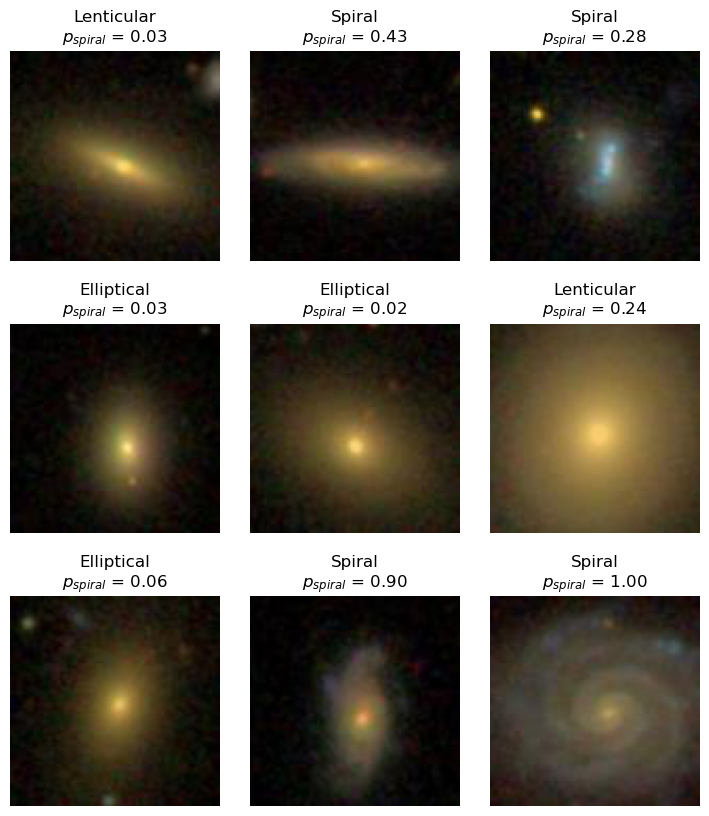

In [15]:
# Show a random set of predictions
plot_images(test_images, test_metadata, spiral_probabilities)

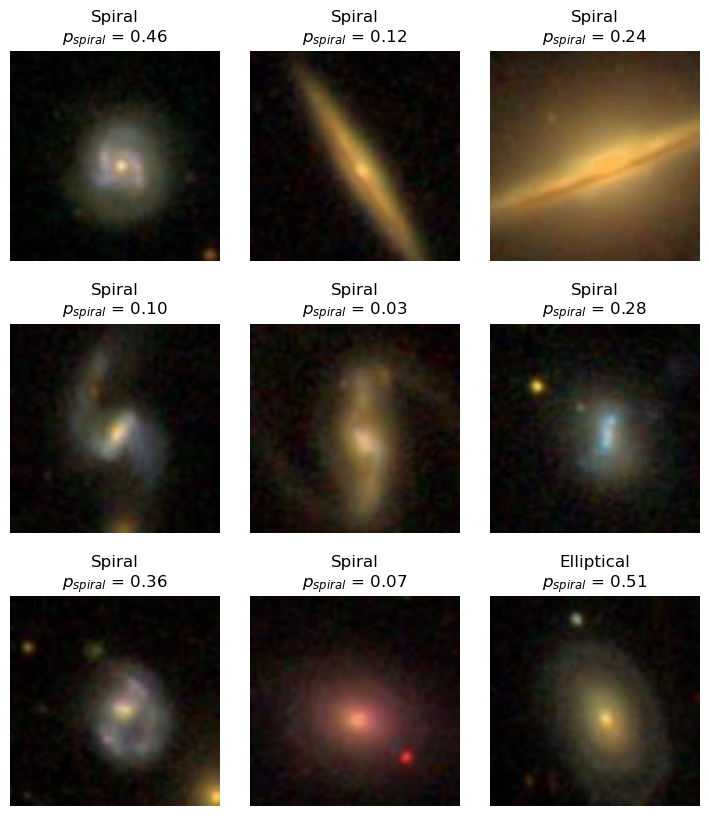

In [16]:
# Show bad predictions
bad_mask = (spiral_probabilities[:, 0] > 0.5) != test_labels
plot_images(test_images[bad_mask], test_metadata[bad_mask], spiral_probabilities[bad_mask])

## Evaluating performance

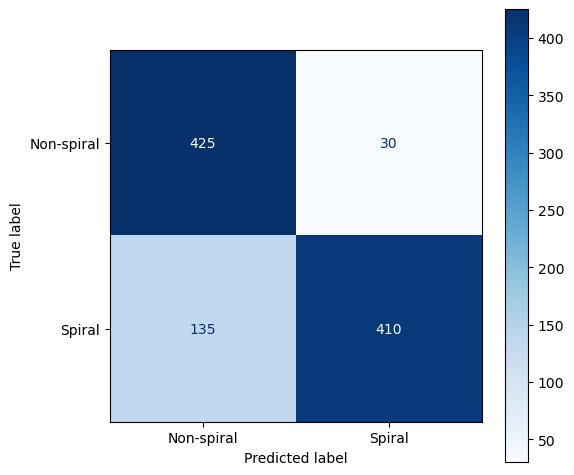

In [17]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(test_labels, spiral_probabilities[:, 0] > 0.5)

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ConfusionMatrixDisplay(matrix, display_labels=['Non-spiral', 'Spiral']).plot(cmap=plt.cm.Blues, ax=ax)

Text(0.5, 1.0, 'AUC = 0.945')

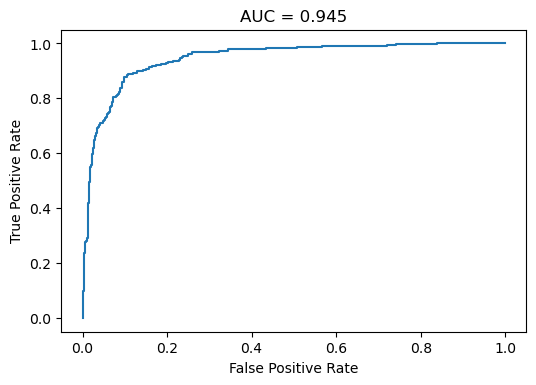

In [18]:
# Generate a ROC curve and measure the Area Under the Curve (AUC)
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_labels, spiral_probabilities)
auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'AUC = {auc:.3f}')

## Exercise

What can we do to improve our classifier?
- Change the architecture.
- Train for longer.
- Use better input data.
- Add additional layers.
- Change the loss function.

Challenge: build the best classifier!

***

# Additional topics

## Representativeness

What happens if our training set is not representative of our test set? Our training dataset is primarily restricted to low-redshift galaxies, so it likely won't generalize well to high-redshift galaxies. This could potentially bias our analysis.

This is especially important to keep in mind when using neural networks for tasks where people are involved. If a group of people isn't represented in the training set, then the model will often produce biased predictions for that group of people when the model is applied to a real dataset.

## Architecture design

How do you choose the best architecture? This is an open question, and a lot of it is trial an error at this point. A good starting point is often to choose an architecture that other people have used and that has done well for similar tasks. e.g. VGG16, ResNet, etc.

## Dropout

Neural networks have a lot of parameters (43,673 for our galaxy classifier!) and can easily overfit the training data. One solution to this is to use dropout where for each training iteration we randomly drop some of the connections. This forces the network to be more robust, and leads to better performance on the validation/test sets.

<div>
<img src="images/dropout.png" width="500"/>
</div>

Try it out! Add a `layers.Dropout` layer to the model.

## Batch normalization

This layer normalizes its input over a batch of inputs so that the mean is close to 0 and the standard deviation is close to 1. This can help with training to prevent weights from getting too high or low. It can also act as a kind of "regularization" for the network and help with overfitting.

Try it out! Add a `layers.BatchNormalization` layer to the model.

## Augmentation

There are many different symmetries in images. We can shift the image in any direction, scale it up or down, rotate it, add noise, etc. By applying small transformations to the input image, we can generate a larger training set which can help improve performance when we have a small training set to begin with.

<div>
<img src="images/augmentation.png" width="500"/>
</div>

Try it out! Use the `ImageDataGenerator` class from `keras.preprocessing.image`. This can be used to apply a wide range of transformations.


## Residual networks

The neural networks that we have discussed so far are limited to ~20 layers. Beyond this, we run into problems with propagating the gradient through the neural network. This can be overcome by adding "shortcut connections" that bypass some of the layers:

<div>
<img src="images/residual_block.png" width="700"/>
</div>

Neural networks built with these kinds of blocks are referred to as "residual networks", and can contain > 100 layers. These networks currently provide the best image classification performance, but they are typically very computationally expensive to train. They can have tens of millions of parameters and require very large training sets.